<a href="https://colab.research.google.com/github/MeldaChen/Group-4/blob/main/%E4%B8%BB%E7%A8%8B%E5%BC%8F%E9%83%A8%E7%BD%B2_1209.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install line-bot-sdk flask flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python3 -m pip install paddlepaddle -i https://mirror.baidu.com/pypi/simple

Looking in indexes: https://mirror.baidu.com/pypi/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install "paddleocr>=2.0.1"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# 引用Web Server套件
from flask import Flask, request, abort, jsonify

# 載入json處理套件
import json

# 外部連結自動生成套件
from flask_ngrok import run_with_ngrok

# 從linebot 套件包裡引用 LineBotApi 與 WebhookHandler 類別
from linebot import (
    LineBotApi, WebhookHandler
)

# 引用無效簽章錯誤
from linebot.exceptions import (
    InvalidSignatureError
)

In [ ]:
'''
建置主程序

建置handler與 line_bot_api
'''

# 設定Server啟用細節
app = Flask(__name__,static_url_path = "/material" , static_folder = "./material/")
run_with_ngrok(app)

# 生成實體物件
line_bot_api = LineBotApi("y5vKOviRTFsN8VP5y4EVl3lpSGOjqmJjOvAnH89ThLyATG4I4kC4dnCZZ0sa8MfZgUyvQCFT/oKLpAVC6ZXjUzDzyl1rBGnuGY4aMo3ewbAV2nIl0kmMY/ae0QsbDQHh08QEk9M6sfZ9wKhcWOZP6QdB04t89/1O/w1cDnyilFU=")
handler = WebhookHandler("8f67c035674deaa1a6c3e6daf96146a3")

In [ ]:
'''
建置主程序的API入口
  接受Line傳過來的消息
  並取出消息內容
  將消息內容存在google drive的檔案內
  並請handler 進行消息驗證與轉發
'''

# 啟動server對外接口，使Line能丟消息進來
@app.route("/", methods=['POST'])
def callback():
    # get X-Line-Signature header value
    signature = request.headers['X-Line-Signature']

    # get request body as text
    body = request.get_data(as_text=True)
    print(body)

    # 記錄用戶log
    f = open("/content/drive/MyDrive/ai-event.log", "a")
    f.write(body)
    f.close()

    # handle webhook body
    try:
        handler.handle(body, signature)
    except InvalidSignatureError:
        abort(400)

    return 'OK'

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import ImageFont, ImageDraw, Image

from paddleocr import PaddleOCR, draw_ocr
from linebot.models import(
    MessageEvent,ImageMessage, TextSendMessage
)
import os

@handler.add(MessageEvent, message=ImageMessage)
def handle_message(event):
    message_content = line_bot_api.get_message_content(event.message.id)
    pic_id = str(event.message.id)+".jpg" #讓每一張圖都可以儲存，未來可再使用
    with open(pic_id, 'wb') as fd:
        for chunk in message_content.iter_content():
            fd.write(chunk)
    m1 = cv2.imread(pic_id, 1)

    copy = m1.copy()

    m1_g = cv2.cvtColor(m1, cv2.COLOR_BGR2GRAY) # 手寫字轉灰階

    ret, m1_new = cv2.threshold(m1_g, 127, 255, cv2.THRESH_BINARY) # 手寫字轉黑底白字

    m1_new_erode = cv2.erode(m1_new, np.ones((3, 3))) #抓字

    erode = cv2.erode(copy, np.ones((30, 30))) #抓字

    gray = cv2.cvtColor(copy, cv2.COLOR_BGR2GRAY) #轉灰階

    blur = cv2.GaussianBlur(gray,(5,5),0)   #模糊化


    canny = cv2.Canny(blur, 70, 210)

    th, canny = cv2.threshold(canny, 10, 255, cv2.THRESH_BINARY)

    morph = cv2.morphologyEx(canny, cv2.MORPH_GRADIENT, np.ones((10, 10))) 
    p, t = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(p)== 1:
        x, y, w, h = cv2.boundingRect(p[0]) 
        cv2.rectangle(m1_new_erode, (x,y), (x+w, y+h), (255, 255, 255), 0) #框線改白色
        capture_img = m1_new_erode[y : y + h, x : x + w] #框起來的地方
        
        new_w = int(50*h/w)
        resize_capture = cv2.resize(capture_img, (50, new_w), interpolation=cv2.INTER_AREA)

        cv2.imwrite("resize_capture.png", resize_capture) #存成 寬50 的手寫字
        resize_capture = cv2.imread("resize_capture.png", 1)


        # Paddleocr目前支持的多语言语种可以通过修改lang参数进行切换
        # 例如`ch`, `en`, `fr`, `german`, `korean`, `japan`
        ocr = PaddleOCR(use_angle_cls=True, lang="ch")  # need to run only once to download and load model into memory
        img_path = pic_id
        result = ocr.ocr(img_path, cls=True)
        for idx in range(len(result)):
            res = result[idx]
            for line in res:
                capture_word = line[-1][0]
                text = capture_word # 取得辨識結果

        compare_word = np.full((100, 100, 3), (255, 255, 255), np.uint8) 
        compare_word = Image.fromarray(compare_word)
        ImageDraw.Draw(compare_word).text((0,0),
                    (text),
                    (0, 0, 0),
                    ImageFont.truetype("ThePeakFontBeta_V0_101.ttf", 55)  #要上傳字體
        )
        compare_word = np.array(compare_word)
        

        

        cv2.imwrite("compare.png", compare_word) # 生成的字存成 compare.png，要再取一次輪廓

        compare_img = cv2.imread('compare.png', 1) 

        copy = compare_img.copy()

        canny = cv2.Canny(copy, 70, 210)

        th, canny = cv2.threshold(canny, 10, 255, cv2.THRESH_BINARY)

        morph = cv2.morphologyEx(canny, cv2.MORPH_GRADIENT, np.ones((3, 3))) 
        p, t = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(p[0]) 
        cv2.rectangle(compare_img, (x,y), (x+w, y+h), (255, 255, 255), 0)  #框線改白色
        cv2.imwrite("compare2.png", compare_img[y : y + h, x : x + w]) #要再resize

        compare2_img = cv2.imread('compare2.png', 1)

        new_w = int(50*h/w)
        resize_compare = cv2.resize(compare2_img, (50, new_w), interpolation=cv2.INTER_AREA)
        cv2.imwrite("resize_compare.png", resize_compare) #存成 寬50 的比對字
      
        # 用resize_capture.png 跟resize_compare.png 比對分數

        def classify_gray_hist(image1,image2,size = (256,256)): 
          img1 = cv2.resize(image1,size) 
          img2 = cv2.resize(image2,size) 
        # 最簡單的以灰度直方圖作為相似比較的實現 
        # def classify_gray_hist(image1,image2,size = (256,256)): 
        # 先計算直方圖 
        # 幾個引數必須用方括號括起來 
        # 這裡直接用灰度圖計算直方圖，所以是使用第一個通道， 
        # 也可以進行通道分離後，得到多個通道的直方圖 
        # bins 取為16 

          hist1 = cv2.calcHist([image1],[0],None,[256],[0.0,255.0]) 
          hist2 = cv2.calcHist([image2],[0],None,[256],[0.0,255.0]) 

        # 計算直方圖的重合度 
          degree = 0 
          for i in range(len(hist1)): 
            if hist1[i] != hist2[i]: 
              degree = degree + (1 - abs(hist1[i]-hist2[i])/max(hist1[i],hist2[i])) 
            else: 
              degree = degree + 1 
          degree = degree/len(hist1) 
          return degree
    
    
        if __name__ == '__main__': 
          img1 = cv2.imread('resize_compare.png') 
          cv2_imshow(img1) 
          img2 = cv2.imread('resize_capture.png') 
          cv2_imshow(img2) 
          degree1 = classify_gray_hist(img1,img2) 
          reply = int(degree1*117)  # 最高分約為 85分，故乘上1.17倍
          if reply >100:
            reply = 100
          reply = str(reply)
          comments = '您的分數是'+reply+'分'
          line_bot_api.reply_message(event.reply_token, TextSendMessage(text=comments))
          message_content = line_bot_api.get_message_content(event.message.id)
          with open(pic_id, 'wb') as fd:
            for chunk in message_content.iter_content():
              fd.write(chunk)


    else:
      comments="請靠近文字重新拍攝再上傳"
      line_bot_api.reply_message(event.reply_token, TextSendMessage(text=comments))

      os.remove(pic_id) # 刪除無法擷取的圖像

      # message_content = line_bot_api.get_message_content(event.message.id)
      # with open(pic_id, 'wb') as fd:
      #   for chunk in message_content.iter_content():
      #     fd.write(chunk)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


INFO:werkzeug: * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://e394-34-85-135-159.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 17:58:03] "POST / HTTP/1.1" 200 -


{"destination":"Ufa901c1e3a406c236ccb56aa04ae3c63","events":[{"type":"unfollow","webhookEventId":"01GK9ZSZANSC0ZZ3KGRF4KG4DV","deliveryContext":{"isRedelivery":false},"timestamp":1670003882841,"source":{"type":"user","userId":"U2ccdc04f5d134177e59e4af39c670d5a"},"mode":"active"}]}


INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 17:58:06] "POST / HTTP/1.1" 200 -


{"destination":"Ufa901c1e3a406c236ccb56aa04ae3c63","events":[{"type":"follow","webhookEventId":"01GK9ZT212E2T3VZAWDWC6Q34Y","deliveryContext":{"isRedelivery":false},"timestamp":1670003885608,"source":{"type":"user","userId":"U2ccdc04f5d134177e59e4af39c670d5a"},"replyToken":"798c667ba0fa413bb7d329dba891035b","mode":"active"}]}
{"destination":"Ufa901c1e3a406c236ccb56aa04ae3c63","events":[{"type":"message","message":{"type":"image","id":"17227878263913","contentProvider":{"type":"line"}},"webhookEventId":"01GK9ZTFS53RF5QH4PFS2XYP0B","deliveryContext":{"isRedelivery":false},"timestamp":1670003900005,"source":{"type":"user","userId":"U2ccdc04f5d134177e59e4af39c670d5a"},"replyToken":"1518ea23dc6a49c89f775a46f181fd50","mode":"active"}]}


INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 17:58:23] "POST / HTTP/1.1" 200 -


{"destination":"Ufa901c1e3a406c236ccb56aa04ae3c63","events":[{"type":"message","message":{"type":"image","id":"17227879559145","contentProvider":{"type":"line"}},"webhookEventId":"01GK9ZVD4FVR7WADVE0W4ZB5NR","deliveryContext":{"isRedelivery":false},"timestamp":1670003929749,"source":{"type":"user","userId":"U2ccdc04f5d134177e59e4af39c670d5a"},"replyToken":"677280e040504024b7b85caba663ddd7","mode":"active"}]}
[2022/12/02 17:58:52] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/whl/det/ch/ch_PP-OCRv3

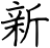

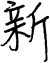

INFO:werkzeug:127.0.0.1 - - [02/Dec/2022 17:58:56] "POST / HTTP/1.1" 200 -


In [ ]:
app.run()